<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Image-Test" data-toc-modified-id="Image-Test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Image Test</a></span></li><li><span><a href="#Array-View" data-toc-modified-id="Array-View-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Array View</a></span></li><li><span><a href="#Tensor-View" data-toc-modified-id="Tensor-View-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Tensor View</a></span></li></ul></li><li><span><a href="#Make-dataframe-with-all-files" data-toc-modified-id="Make-dataframe-with-all-files-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make dataframe with all files</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Traditional-Methods" data-toc-modified-id="Traditional-Methods-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Traditional Methods</a></span></li></ul></div>

## Libraries

In [46]:
# usual suspects
import os
import time
import shutil
import requests
import zipfile
from PIL import Image

import numpy as np
import pandas as pd
from cycler import cycler

# the good stuff
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

# standard sklearn import
from sklearn.metrics import accuracy_score

# minor changes to plotting functions
import matplotlib.pyplot as plt
cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c


%matplotlib inline
%config InlineBackend.figure_format='retina'

# change margin size of jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Preprocessing 

### Image Test

In [75]:
img_path = "./data/Futurama/character02/0326_16.png"
image = Image.open(img_path)

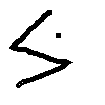

In [76]:
image

### Array View

In [77]:
Image.open(img_path).convert("L")
img = np.array(img)
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### Tensor View

In [78]:
image = transforms.ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
image = Variable(image)
image

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

## Make dataframe with all files

In [68]:
language_dict = {}
i = 0
for language in os.listdir("./data"):
    for char in os.listdir("./data/{}".format(language)):
        for file in os.listdir("./data/{}/{}".format(language, char)):
            #Make empty data frame
            language_dict[i] = {}
            
            #Bring in file information
            language_dict[i]['language'] = language
            language_dict[i]['char'] = char
            language_dict[i]['file'] = file
            language_dict[i]['path'] = "./data/{}/{}/{}".format(language,
                                                                char,
                                                                file)
            
            #Image to array
            img = Image.open(language_dict[i]['path']).convert("L")
            img = np.array(img)
            language_dict[i]['image_array'] = img
            
            #Import image as tensor
            image = Image.open(language_dict[i]['path'])
            image = transforms.ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
            image = Variable(image)
            language_dict[i]['image_tensor'] = image
            
            #Add onto index
            i += 1

#Set and name dataframe
omni = pd.DataFrame.from_dict(language_dict).T

#build target column
omni["target"] = omni["language"] + "_" + omni["char"]
omni.head()

,language,char,file,path,image_array,image_tensor,target
0,Futurama,character02,0326_20.png,./data/Futurama/character02/0326_20.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,...",Futurama_character02
1,Futurama,character02,0326_04.png,./data/Futurama/character02/0326_04.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,...",Futurama_character02
2,Futurama,character02,0326_09.png,./data/Futurama/character02/0326_09.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,...",Futurama_character02
3,Futurama,character02,0326_15.png,./data/Futurama/character02/0326_15.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,...",Futurama_character02
4,Futurama,character02,0326_11.png,./data/Futurama/character02/0326_11.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,...",Futurama_character02


## Train Test Split

In [81]:
from sklearn.model_selection import train_test_split

X = omni[["image_array", "image_tensor"]]
y = omni["target"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=88)

## Traditional Methods

In [82]:
X_train_tradition = X_train["image_arrau"]
X_test_tradition = X_test[]

,image_array,image_tensor
1099,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
6149,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
9231,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
7276,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
4644,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
31080,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
27283,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
5251,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
27636,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
23653,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."
